In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Sampling From the Distributions With Random Walk Metropolis

We introduce the concept of random walk in 1D and 2D because it is the backbone of many sampling algorithms.
We use the Metropolis algorithm (the simplest Markov Chain Monte Carlo (MCMC) algorithm) to sample from an arbitrary probability density known up to a normalization constant.
We learn how to diagnose the convergence of MCMC algorithms by monitoring the acceptance rate and autocorrelation.
We use MCMC to calibrate the reaction kinetics problem using the Bayesian formulation.


## Attention

We implement the Metropolis algorithm from scratch. 
This is to see what is behind the `pyro` implementation.
Also, note that the results below need to be corrected! You are supposed to follow the discussion and answer questions to get the correct results!

## Example 1: Random walk in 1D.

Random walk in 1D is one of the most basic Markov chains.
It will be the building block for the Metropolis algorithm.
The *state space* is:

$$
\mathcal{X} = \mathbb{R}.
$$

The *transition kernel* is:

$$
p(x_{n+1}|x_n) \equiv T(x_{n},x_{n+1}) := \mathcal{N}\left(x_{n+1}|x_n,\sigma^2\right) = \left(2\pi\sigma^2\right)^{-\frac{1}{2}}\exp\left\{-\frac{\left(x_{n+1}-x_n\right)^2}{2\sigma^2}\right\},
$$

for some parameter $\sigma>0$.
An alternative way of writing the same thing is:

$$
X_{n+1} = X_n + \sigma Z_n,
$$

where $Z_1,\dots,Z_n\sim \mathcal{N}(0,1)$ independent random variables.

Let's visualize it:

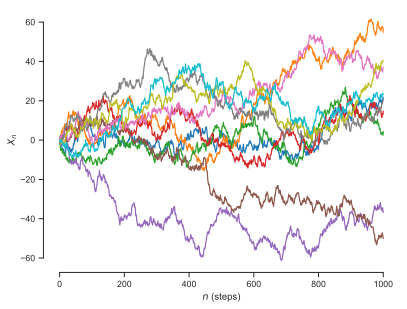

In [2]:
# Pick a starting point for your random walk
x0 = 0.
# Pick a standard deviation for your random walk
sigma = 1
# Pick the number of steps you want to simulate
n = 1000
# How many different sample paths of the process do you want to simulate
n_paths = 10
# We will be plotting in here:
fig, ax = plt.subplots()
# Loop over the paths
for _ in range(n_paths):
    # Simulate a single path
    X = np.ndarray((n + 1,))
    X[0] = x0
    for t in range(1, n + 1):
        Zt = np.random.randn()
        X[t] = X[t-1] + sigma * Zt
    # Let's plot it
    ax.plot(range(n+1), X)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
sns.despine(trim=True);

### Questions
+ Increase the number of steps $n$ from 1,000 to 10,000 to 100,000. Run it a couple of times for each case. What do you observe?
+ Get the number of steps $n$ down to 1,000. Increase $\sigma$ to 0.1 to 1. What do you observe for the values of $X$?
+ Plot ten different sample paths from the random walk process.

## Example 2: Random Walk in Higher-dimensions.

The random walk can be generalized to arbitrary dimensions.
The *state space* is:

$$
\mathcal{X} = \mathbb{R}^d.
$$

The *transition kernel* is:

$$
p(x_{n+1}|x_n) \equiv T(x_{n},x_{n+1}) := \mathcal{N}\left(x_{n+1}|x_n,\Sigma\right) = \left(2\pi\right)^{-\frac{d}{2}}|\Sigma|^{-\frac{1}{2}}\exp\left\{-\frac{1}{2}(x_{n+1}-x_n)^T\Sigma^{-1}(x_{n+1}-x_n)\right\},
$$

for some positive definite covariance matrix $\Sigma\in\mathbb{R}^{d\times d}$.

An alternative way of writing the same thing is:

$$
X_{n+1} = X_n + A Z_n,
$$

where $Z_1,\dots,Z_n\sim \mathcal{N}(0,I_d)$ independent random vectors, and $A\in\mathbb{R}^{d\times d}$ is a square root of $\Sigma$, e.g., the Cholesky decomposition.

Let's visualize it for two dimensions:

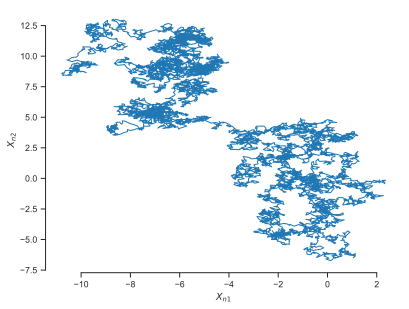

In [3]:
# Pick a starting point for your random walk
x0 = np.zeros((2,))
# Pick a standard deviation for your random walk
sigma1 = 0.1
sigma2 = 0.1
Sigma = np.diag([sigma1 ** 2, sigma2 ** 2])
A = np.linalg.cholesky(Sigma)
# Pick the number of steps you want to simulate
n = 10000
# How many different sample paths of the process do you want to simulate
n_paths = 1
# We will be plotting in here:
fig, ax = plt.subplots()
# Loop over the paths
for _ in range(n_paths):
    # Simulate a single path
    X = np.ndarray((n + 1, 2))
    X[0, :] = x0
    for t in range(1, n + 1):
        Zt = np.random.randn(2)
        X[t, :] = X[t-1] + np.dot(A, Zt)
    # Let's plot it
    ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$X_{n1}$')
ax.set_ylabel('$X_{n2}$')
sns.despine(trim=True);

### Questions
+ Increase the number of steps $n$ from 1,000 to 10,000 to 100,000. Run it a couple of times for each case. What do you observe?
+ Get the number of steps $n$ down to 1,000. Increase $\sigma$ to 0.1 to 1. What do you observe for the values of $X$?
+ Plot ten different sample paths from the random walk process.

## The Metropolis Algorithm

Now, let's get back to the initial problem of sampling:

$$
\pi(x) = \frac{h(x)}{Z},
$$

without knowing $Z$.
{cite:p}`metropolis1953` demonstrated constructing a Markov chain with $\pi(x)$ as the equilibrium density.
The algorithm is based on biasing an underlying symmetric, stationary Markov chain.
Let $T(x,x')$ be the transition kernel of this underlying Markov chain (also called the *proposal distribution*).
The transition kernel must be symmetric, i.e.,

$$
T(x,x') = T(x',x).
$$

A widespread choice of the proposal distribution is the random walk transition kernel:

$$
T(x,x') = \mathcal{N}(x'|x, \Sigma).
$$

However, this is just one possibility.
Once we have picked a proposal, we construct the desired Markov chain as follows:

+ **Initialization:** Pick an arbitrary starting point $x_0$.
+ For each time step $n$:
    - **Generation:** Sample a candidate $x$ from $T(x_n, x)$.
    - **Calculation:** Calculate the *acceptance ratio*:

    $$
    \alpha(x_n, x) = \min\left\{1, \frac{h(x)}{h(x_n)}\right\}.
    $$
    
    This is the only place where you may need to evaluate the underlying model.
    - **Accept/Reject:**
        - Generate a uniform number $u\sim \mathcal{U}([0,1])$.
        - If $u\le \alpha$, *accept* and set $x_{n+1}=x$.
        - If $u > \alpha$, *reject* ad set $x_{n+1} = x_n$.
        
Here is a generic implementation. We use the $\log h(x)$ for numerical stability.

In [4]:
def rwmetropolis(x0, log_h, n, sigma, args=()):
    """Random walk metropolis.
    
    Arguments:
    x0     -- The initial point (numpy array).
    log_h  -- The logartihm of the function that is proportional
              to the density you want to sample from (function).
    n      -- The maximum number of steps you want to take.
    sigma  -- The standard deviation of the random walk proposal.
    args   -- Any parameters to log_h.

    Returns:
    X, acceptance_rate
    """
    x0 = np.array(x0)
    assert x0.ndim == 1
    # Dimensionality of space
    d = x0.shape[0]
    # A place to store the samples
    X = np.ndarray((n + 1, d))
    X[0, :] = x0
    # Previous value of log(h(x))
    log_h_p = log_h(x0, *args)
    # Keep track of how many samples are accepted
    count_accepted = 0
    # Start the simulation
    for t in range(1, n + 1):
        # Generation
        x = X[t - 1, :] + sigma * np.random.randn(d)
        # Calculation
        log_h_c = log_h(x, *args) # Current value of log(h(x))
        alpha = min(1, np.exp(log_h_c - log_h_p))
        # Accept/Reject
        u = np.random.rand()
        if u <= alpha: # Accept
            X[t, :] = x
            log_h_p = log_h_c
            count_accepted += 1
        else:          # Reject
            X[t, :] = X[t - 1, :]
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate

## Example 3: Sampling from an Exponential using Random Walk Metropolis

Let's take $\mathcal{X}=(0,\infty)$ and:

$$
\pi(x) \propto e^{-10x}.
$$

This is proportional to an exponential density with rate $\lambda=10$.
Of course, we know that the normalization constant is $Z=1/10$, but we are not going to use it.
As a proposal distribution, we will use a simple random walk:

$$
T(x_n,x) = \mathcal{N}(x|x_n, \sigma^2),
$$

and we will just pick $\sigma>0$ by hand.
Here we go:

In [7]:
# A function proportional to the logarithm of the density from which you wish to sample.
# (We always work with the log for numerical stability)
def log_h(x):
    if x[0] < 0:
        return -1e99 # Negative values are not allowed - Give back something very negative
    return -10. * x[0]  # The log of h(x)

# Initialiazation:
x0 = np.array([10.])
# Parameters of the proposal:
sigma = 1.0
# Number of steps
n = 10000

X, acceptance_rate = rwmetropolis(x0, log_h, n, sigma)

print('Acceptance rate: %1.2f' % acceptance_rate)

Acceptance rate: 0.08


The acceptance rate gives the percentage of steps with an accepted move.
For a local proposal distribution (like our random walk above), we need help to keep the acceptance rate between 0.2 and 0.6. This can be done by adjusting the size of the proposed steps.
In general:
+ If the acceptance rate is too low, our chain moves too ambitiously.
+ If the acceptance rate is too high, our chain needs to be more ambitious.

### Questions

+ Choose `sigma` to make the acceptance rate around $0.25$. This is how `pyro` does tuning. Hint: Try `sigma=0.1`, `sigma=0.2`, etc., until you get the desired acceptance rate.

Let's visualize the chain:

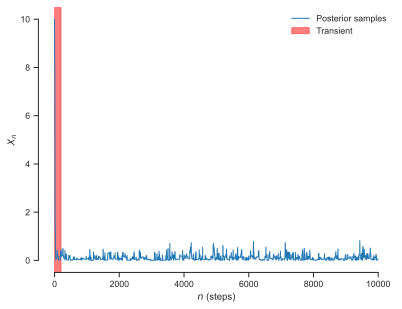

In [8]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1, label='Posterior samples')
ax.axvspan(0, 200, alpha=0.5, color='red', label='Transient')
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
plt.legend(frameon=False)
sns.despine(trim=True);

By construction, samples from this chain are supposed to be samples from the correct probability distribution.
There are, however, two issues:

+ Ergodicity guarantees samples only for large $n>n_b$.
At the beginning, the chain exhibits transient behavior. We have colored this region red.
What we need to do is *burn* these initial samples, i.e., we throw them away.
The only reason to see the transient regime is to study the chain path in the figure above.

+ Consecutive samples are highly correlated (as the chain state does not change if a move is rejected).
Ideally, we want as independent samples as possible.
To achieve this, we need to throw samples in between.
This is called *thinning* the process.
To figure out how to thin the process, you need to look at the *autocorrelation* of the process.
Since we have a stationary process, the autocorrelation is expressed as a function of the time lag $k$ between two steps $n$ and $n+k$:

$$
R(k) = \frac{\mathbb{E}\left[(X_n - \mu)(X_{n+k}-\mu)\right]}{\sigma^2}.
$$

Ideally, you want to think every $k*$ so that:

$$
R(k^*) \approx 0.
$$

That is, you would pick $X_{n_b + k^*}, X_{n_b + 2k*},\dots$.
These samples will look independent.

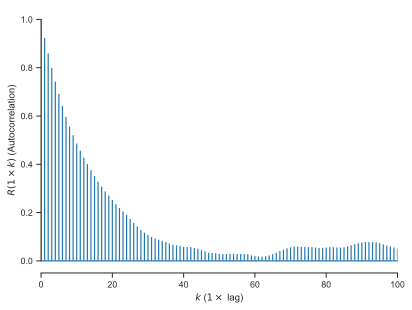

In [9]:
# How many samples do you want to burn?
burn = 200
# How many samples do you want to throw in between?
thin = 1 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
fig, ax = plt.subplots()
ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=100)
ax.set_xlim(0, 100)
ax.set_ylabel(r'$R(%d \times k)$ (Autocorrelation)' % thin)
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin)
sns.despine(trim=True);

If you have chosen ``burn`` and ``thin`` the right way (see questions), you should see samples that look almost independent.
Let's test this:

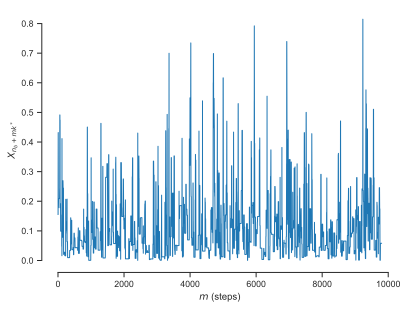

In [10]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=1.)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_b+m k^*}$')
sns.despine(trim=True);

Let's estimate the mean and the variance by sampling average and compare them to the true values.
**Note:** It is also possible to get error bars because the CLT holds (if certain regularity condtions hold), but we do not do it here.

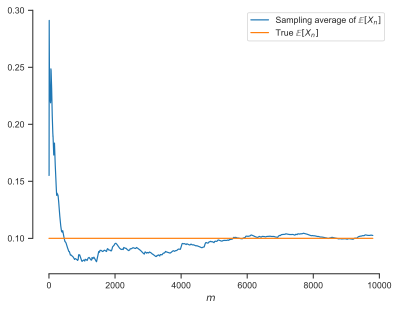

In [12]:
fig, ax = plt.subplots()
idx = np.arange(1, X_rest.shape[0] + 1)
X_ave = np.cumsum(X_rest) / idx
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_n]$')
ax.plot(idx, 0.10 * np.ones(idx.shape[0]), label='True $\mathbb{E}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$')
sns.despine(trim=True);

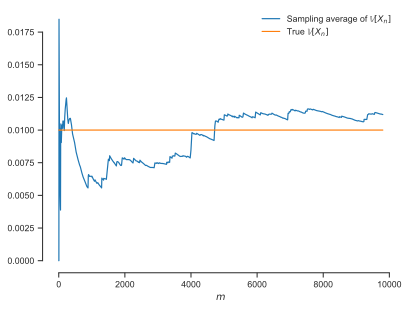

In [13]:
fig, ax = plt.subplots()
X2_ave = np.cumsum(X_rest ** 2) / idx
X_var = X2_ave - X_ave ** 2
ax.plot(idx, X_var, label='Sampling average of $\mathbb{V}[X_n]$')
ax.plot(idx, 0.01 * np.ones(idx.shape[0]), label='True $\mathbb{V}[X_n]$')
plt.legend(loc='best', frameon=False)
ax.set_xlabel('$m$')
sns.despine(trim=True);

Now, let's use these *independent* variables to draw the empirical histrogram and compare it to the true density:

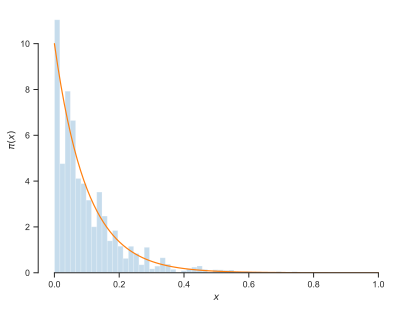

In [14]:
fig, ax = plt.subplots()
ax.hist(X_rest, density=True, alpha=0.25, bins=50);
xx = np.linspace(0, 1, 100)
ax.plot(xx, 10. * np.exp(-10. * xx))
ax.set_xlabel('$x$')
ax.set_ylabel('$\pi(x)$')
sns.despine(trim=True);

### Questions:

+ Choose ``burn`` so that you ignore the transient regime of the process. How does this affect your averages and your histograms?

+ Choose ``thin`` ($k^*$) to make the autocorrelation almost zero. How does this affect your averages and your histograms?

## Example 4: Sampling from a Beta using Random Walk Metropolis

Let's take $\mathcal{X}=(0,1)$ and:

$$
\pi(x) \propto x^{\alpha-1}(1-x)^{\beta - 1}.
$$

As a proposal distribution, we will use a simple random walk:

$$
T(x_n,x) = \mathcal{N}(x|x_n, \sigma^2),
$$

and we will just pick $\sigma>0$ by hand.
Here we go:

In [49]:
def log_h_beta(x, alpha, beta):
    if x[0] <= 0 or x[0] >= 1:
        return -1e99
    return (alpha - 1.) * np.log(x[0]) + (beta - 1.) * np.log(1. - x[0])

# Initialiazation:
x0 = np.array([.5])
# Parameters of the proposal:
sigma = .1
# Number of steps
n = 1000000
# For which alpha and beta do you want to run it?
alpha = .1
beta = .1

# Start sampling
X, acceptance_rate = rwmetropolis(x0, log_h_beta, n, sigma, args=(alpha, beta))

print(f"Aceptance rate: {acceptance_rate}")

Aceptance rate: 0.307704


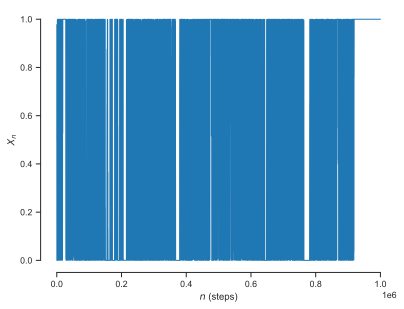

In [50]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
sns.despine(trim=True);

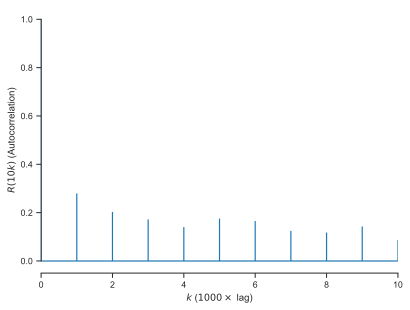

In [51]:
# How many samples do you want to burn?
burn = 10
# How many samples do you want to throw in between?
thin = 1000 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
fig, ax = plt.subplots()
ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=10)
ax.set_xlim(0, 10)
ax.set_ylabel('$R(10k)$ (Autocorrelation)')
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin)
sns.despine(trim=True);

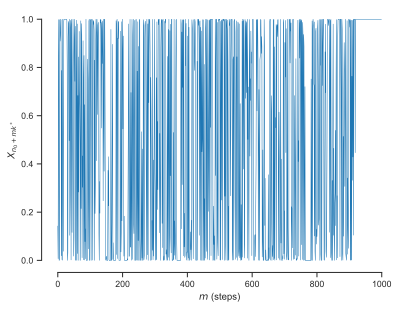

In [52]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$')
sns.despine(trim=True);

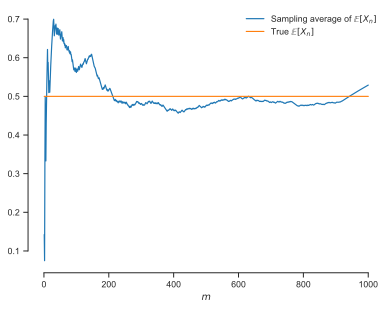

In [53]:
fig, ax = plt.subplots()
idx = np.arange(1, X_rest.shape[0] + 1)
X_ave = np.cumsum(X_rest) / idx
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_n]$')
ax.plot(idx, alpha / (alpha + beta) * np.ones(idx.shape[0]), label='True $\mathbb{E}[X_n]$')
plt.legend(loc='best', frameon=False)
ax.set_xlabel('$m$')
sns.despine(trim=True);

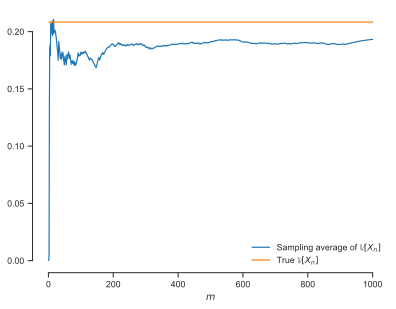

In [54]:
fig, ax = plt.subplots()
X2_ave = np.cumsum(X_rest ** 2) / idx
X_var = X2_ave - X_ave ** 2
ax.plot(idx, X_var, label='Sampling average of $\mathbb{V}[X_n]$')
ax.plot(idx, alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1)) * np.ones(idx.shape[0]), label='True $\mathbb{V}[X_n]$')
plt.legend(loc='best', frameon=False)
ax.set_xlabel('$m$')
sns.despine(trim=True);

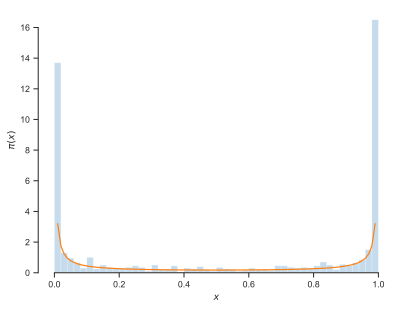

In [55]:
fig, ax = plt.subplots()
ax.hist(X_rest, density=True, alpha=0.25, bins=50);
xx = np.linspace(0, 1, 100)
ax.plot(xx, st.beta(alpha, beta).pdf(xx))
ax.set_xlabel('$x$')
ax.set_ylabel('$\pi(x)$')
sns.despine(trim=True);

### Questions

+ For $\alpha = 2, \beta=5$ do the following:
    - find the $\sigma$ that gives you an acceptance rate of about $0.25$.
    - find how many samples $n_b$ you need to burn to get over the transient (if any).
    - find how many samples $k^*$ you need to drop in between to drive the autocorrelation down to almost zero.
    
+ Repeat the steps above for $\alpha = 0.5$ and $\beta=0.5$. What do you observe now that you have two modes?

+ Repeat the steps above for $\alpha = 0.1$ and $\beta=0.1$. What do you observe now that your modes are even more pronounced?

## Example 5: Sampling from a Gaussian with Random Walk Metropolis

Let's take $\mathcal{X}=\mathbb{R}^2$ and:

$$
\pi(x) \propto \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$

where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
As a proposal distribution, we will use a simple random walk:

$$
T(x_n,x) = \mathcal{N}(x|x_n, \sigma^2 I_2),
$$

and we will just pick $\sigma>0$ by hand.
Here we go:

In [56]:
# The log of the density (up to a normalizing constant) of the distribution from which we want to sample:
def log_h_mvn(x, mu, Lambda):
    tmp = x - mu
    return -0.5 * np.dot(tmp, np.dot(Lambda, tmp))

# The parameters of the disribution from which we wish to sample
mu = np.array([5., 2.])
Sigma = np.array([[1., .4],
                  [.3, 0.2]]) # This has to be positive definite - otherwise you will get garbage!
Lambda = np.linalg.inv(Sigma)

# Initialiazation:
x0 = np.array([-5., 5.])
# Parameters of the proposal:
sigma = 0.2
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = rwmetropolis(x0, log_h_mvn, n, sigma, args=(mu, Lambda))

print(f"Aceptance rate: {acceptance_rate}")

Aceptance rate: 0.7555


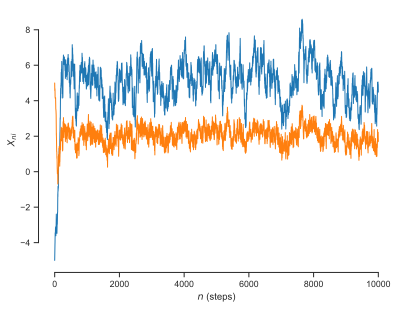

In [57]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$')
sns.despine(trim=True);

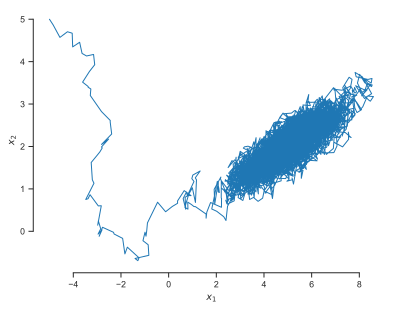

In [58]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

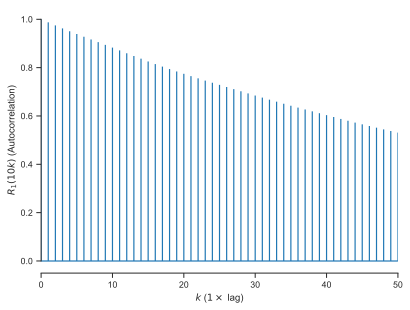

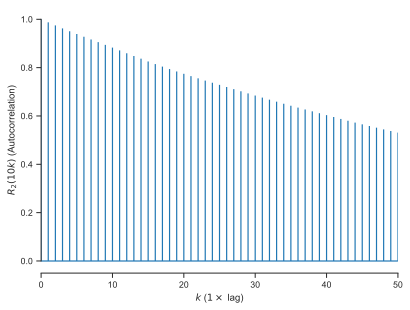

In [59]:
# How many samples do you want to burn?
burn = 100
# How many samples do you want to throw in between?
thin = 1 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(10k)$ (Autocorrelation)' % (i + 1))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin)
    sns.despine(trim=True);

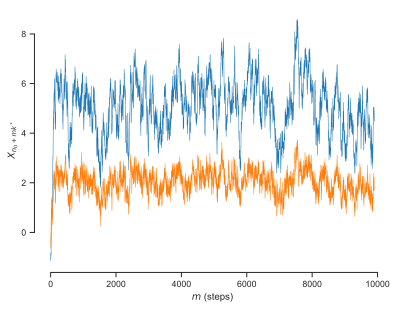

In [60]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$')
sns.despine(trim=True);

### Questions

+ For the case shown:
    - Find the $\sigma$ that gives you an acceptance rate of about $0.25$.
    - Find how many samples $n_b$ you need to burn to get over the transient (if any).
    - Find how many samples $k^*$ you need to drop in between to drive the autocorrelation down to almost zero.